# **Time Series ML with LSTM with Keras (TF 2.0)**: data prep

This notebook is based on **Multivariate Time Series Forecasting with LSTMs in Keras** by **Jason Brownlee** for me practicing time series ML with LSTM. 
The great original work is here https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

This notebook only deals with simple preprocessing. The raw data is a Beijing PM2.5 dataset. The following addition works have been done beyond the original work.

1. make wind direction to one hot encoded.
2. add 'doy' (day of year) column to introduce possible seasonal feature
3. add 'hour' column since it's clearly hour dependent from mean pm2.5 vs hour plot.

Processed dataset is saved for further preparation for feeding the LSTM model.













In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import pydot
import os

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

#import tensorflow as tf
#print(tf.__version__)


#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import LearningRateScheduler

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')




## **Exploring and processing data**


In [0]:
#format raw data

# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
 
gdrive="/content/gdrive/My Drive/Colab Notebooks/time series/data/"

dataset = pd.read_csv(gdrive + 'beijing_pm25_raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)


In [68]:
#format

dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pm2.5', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pm2.5'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]

# save to file
#dataset.to_csv(gdrive + 'beijing_pm25_col.csv')

dataset.head(5)

,pm2.5,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


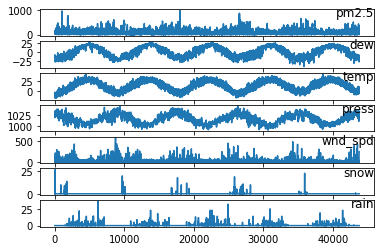

In [69]:
# display
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
plt.figure()
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

In [70]:
dataset.describe()

,pm2.5,dew,temp,press,wnd_spd,snow,rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,94.013516,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,92.252276,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,68.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,132.250000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [71]:
dataset.describe(include=['O'])

,wnd_dir
count,43800
unique,4
top,SE
freq,15290


In [72]:
dataset.isnull().sum()

pm2.5      0
dew        0
temp       0
press      0
wnd_dir    0
wnd_spd    0
snow       0
rain       0
dtype: int64

In [73]:
# check missing pm2.5 data

dataset[dataset['pm2.5']==0].shape[0]

2045

In [74]:
# check wind directions

dataset.wnd_dir.value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [75]:
for wnd_dir in dataset.wnd_dir.unique():
  print('wnd_dir: {0}, pm2.5: mean={1:.1f}, stdev={2:.1f}'.format(wnd_dir, dataset.loc[dataset.wnd_dir==wnd_dir,'pm2.5'].mean(), dataset.loc[dataset.wnd_dir==wnd_dir,'pm2.5'].std()))


wnd_dir: SE, pm2.5: mean=105.6, stdev=81.6
wnd_dir: cv, pm2.5: mean=120.2, stdev=101.6
wnd_dir: NW, pm2.5: mean=66.9, stdev=88.2
wnd_dir: NE, pm2.5: mean=85.8, stdev=94.9


In [0]:
# one hot encoder for wind directions
wnd_dir_one_hot=pd.get_dummies(dataset['wnd_dir'], prefix='wnd_dir')
dataset=pd.concat([dataset, wnd_dir_one_hot], axis=1)
dataset.drop('wnd_dir', axis=1, inplace=True)

In [0]:
# add 'day of year' and 'hour'

dataset['doy']=dataset.index.dayofyear
dataset['hour']=dataset.index.hour

In [0]:
data_doy=pd.Series(dataset.loc[dataset.doy==doy,'pm2.5'].mean() for doy in dataset.doy.unique())

In [79]:
data_doy.head()

0    86.258333
1    68.466667
2    76.508333
3    69.258333
4    94.750000
dtype: float64

In [0]:
data_hour=pd.Series(dataset.loc[dataset.hour==hour,'pm2.5'].mean() for hour in dataset.hour.unique())

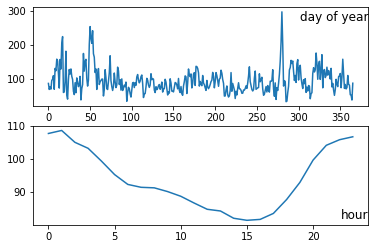

In [81]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(data_doy)
plt.title('day of year', y=.8, loc='right')
plt.subplot(2, 1, 2)
plt.plot(data_hour)
plt.title('hour', y=0, loc='right')
plt.show()

In [82]:
dataset.head(10)

,pm2.5,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NE,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv,doy,hour
date,,,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0,2,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0,2,1
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0,2,2
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0,2,3
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0,2,4
2010-01-02 05:00:00,109.0,-7,-6.0,1022.0,7.14,3,0,0,0,1,0,2,5
2010-01-02 06:00:00,105.0,-7,-6.0,1023.0,8.93,4,0,0,0,1,0,2,6
2010-01-02 07:00:00,124.0,-7,-5.0,1024.0,10.72,0,0,0,0,1,0,2,7
2010-01-02 08:00:00,120.0,-8,-6.0,1024.0,12.51,0,0,0,0,1,0,2,8


In [83]:
dataset.dtypes

pm2.5         float64
dew             int64
temp          float64
press         float64
wnd_spd       float64
snow            int64
rain            int64
wnd_dir_NE      uint8
wnd_dir_NW      uint8
wnd_dir_SE      uint8
wnd_dir_cv      uint8
doy             int64
hour            int64
dtype: object

In [0]:
dataset.to_csv(gdrive + 'beijing_pm25_dp.csv')




# **Credit**

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


